In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [3]:
def modelEvaluation(pipeline, X, y, X_test, y_test):
    if isinstance(pipeline, Pipeline):
        model = pipeline.named_steps['rf']
    else:
        model = pipeline

    importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)


    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    
    y_pred = pipeline.predict(X_test)
    print(f"CV Accuracy: {scores.mean() * 100:.2f}%")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=[str(c) for c in model.classes_]))


    cm = confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    topImportances = importances.head(15)
    axes[0].barh(topImportances['Feature'], topImportances['Importance'], color="skyblue")
    axes[0].invert_yaxis()
    axes[0].set_xlabel("Importance")
    axes[0].set_title("Feature Importances")

    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                ax=axes[1],
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [4]:
def tuneHyperparameters(X_train, y_train):
    pipe = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ])

    paramDist = {
        'rf__n_estimators': [200, 300, 400],
        'rf__max_depth': [6, 8, 10, 12],
        'rf__min_samples_split': [3, 5, 7, 10],
        'rf__min_samples_leaf': [2, 3, 4],
        'rf__max_features': ['sqrt', 'log2']
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    search = RandomizedSearchCV(estimator=pipe,
                                param_distributions=paramDist,
                                n_iter=15,
                                cv=cv,
                                scoring='f1_macro',
                                random_state=42,
                                n_jobs=-1)

    search.fit(X_train, y_train)
    print("Best parameters:", search.best_params_)
    print("Best CV F1-macro:", search.best_score_)
    return search.best_estimator_

# Cáncer de pulmón

In [5]:
pulmonData = pd.read_csv("../data/survey lung cancer.csv")

In [6]:
pulmonData.isnull().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64

In [7]:
pulmonData.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [8]:
pulmonData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [9]:
binary_cols = [
    'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
    'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
    'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
    'SWALLOWING DIFFICULTY', 'CHEST PAIN'
]

pulmonData[binary_cols] = pulmonData[binary_cols].replace({1: 0, 2: 1})
pulmonData['GENDER'] = pulmonData['GENDER'].replace({'F': 0, 'M':1})

C:\Users\arife\AppData\Local\Temp\ipykernel_24120\4181604899.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pulmonData['GENDER'] = pulmonData['GENDER'].replace({'F': 0, 'M':1})


In [10]:
pulmonData['LUNG_CANCER'].value_counts()

LUNG_CANCER
YES    270
NO      39
Name: count, dtype: int64

In [11]:
X = pulmonData.drop(columns=['LUNG_CANCER'])
y = pulmonData['LUNG_CANCER']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=42,
    stratify=y
)

In [14]:
pulmonPipe = tuneHyperparameters(X, y)

Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_features': 'sqrt', 'rf__max_depth': 6}
Best CV F1-macro: 0.798241591365928


In [15]:
pulmonPipe = pulmonPipe.fit(X_train, y_train)

In [16]:
y_pred_pulmon = pulmonPipe.predict(X_test)

CV Accuracy: 91.59%
Accuracy: 88.71%

Classification Report:

              precision    recall  f1-score   support

          NO       0.57      0.50      0.53         8
         YES       0.93      0.94      0.94        54

    accuracy                           0.89        62
   macro avg       0.75      0.72      0.73        62
weighted avg       0.88      0.89      0.88        62



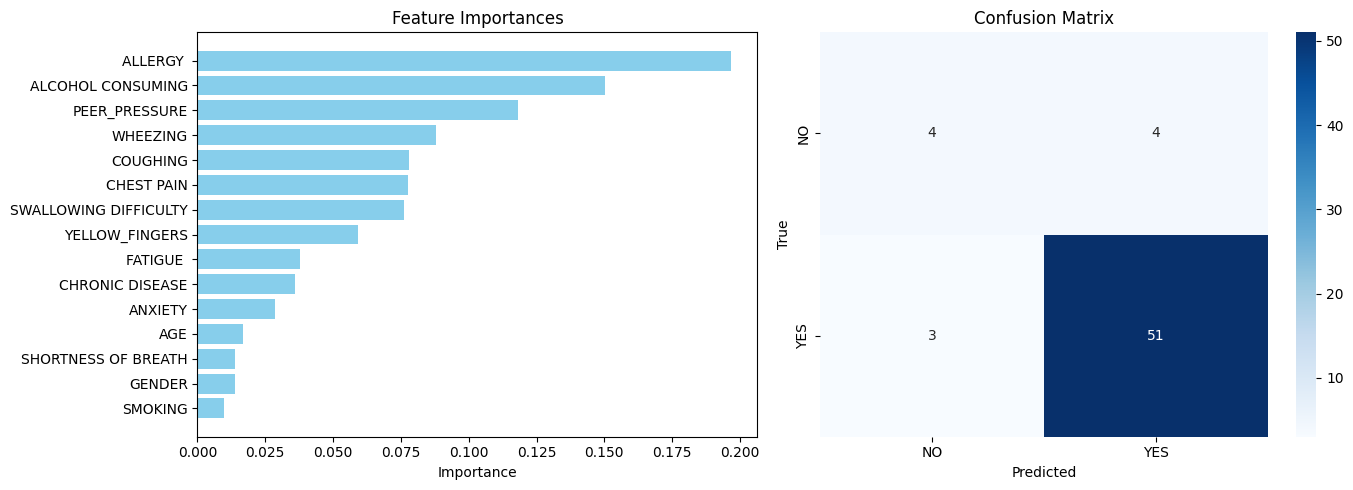

In [17]:
modelEvaluation(pulmonPipe, X, y, X_test, y_test)

# Cáncer de próstata

In [18]:
prostataData = pd.read_csv("../data/Prostate_Cancer_Dataset.csv")

In [19]:
prostataData.head()

,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension,diagnosis_result
0,23.0,12.0,151.0,954.0,0.143,0.278,0.242,0.079,M
1,9.0,13.0,133.0,1326.0,0.143,0.079,0.181,0.057,B
2,21.0,27.0,130.0,1203.0,0.125,0.160,0.207,0.060,M
3,14.0,16.0,78.0,386.0,0.070,0.284,0.260,0.097,M
4,9.0,19.0,135.0,1297.0,0.141,0.133,0.181,0.059,M


In [20]:
prostataData.isnull().sum()

radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
symmetry             0
fractal_dimension    0
diagnosis_result     0
dtype: int64

In [21]:
prostataData['diagnosis_result'].value_counts()

diagnosis_result
M    361
B    239
Name: count, dtype: int64

In [22]:
X = prostataData.drop(columns=['diagnosis_result'])
y = prostataData['diagnosis_result'].replace({'M': 1, 'B': 0})

C:\Users\arife\AppData\Local\Temp\ipykernel_24120\2482777454.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = prostataData['diagnosis_result'].replace({'M': 1, 'B': 0})


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=42,
    stratify=y
)

In [24]:
prostataPipe = tuneHyperparameters(X, y)

Best parameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 10}
Best CV F1-macro: 0.9808690493150035


In [25]:
prostataPipe = prostataPipe.fit(X_train, y_train)

In [26]:
y_pred = prostataPipe.predict(X_test)

CV Accuracy: 98.67%
Accuracy: 97.50%

Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        48
           1       1.00      0.96      0.98        72

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



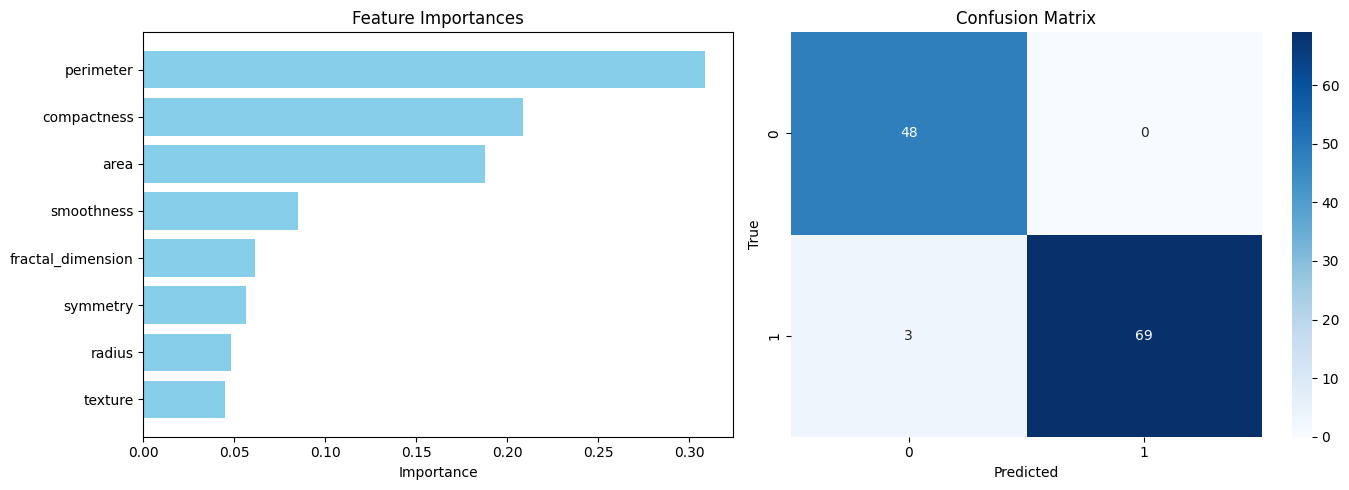

In [27]:
modelEvaluation(prostataPipe, X, y, X_test, y_test)

# Cáncer de mama

In [28]:
mamaData = pd.read_csv("../data/breast-cancer-wisconsin-data_data.csv")

In [29]:
mamaData.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [30]:
mamaData.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [31]:
mamaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [32]:
mamaData['diagnosis'] = mamaData['diagnosis'].replace({'M':1, 'B':0})

C:\Users\arife\AppData\Local\Temp\ipykernel_24120\444562800.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mamaData['diagnosis'] = mamaData['diagnosis'].replace({'M':1, 'B':0})


In [34]:
X = mamaData.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
y = mamaData['diagnosis']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=42,
    stratify=y
)

In [36]:
mamaPipe = tuneHyperparameters(X, y)

Best parameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 3, 'rf__max_features': 'sqrt', 'rf__max_depth': 10}
Best CV F1-macro: 0.9589601521836562


In [37]:
mamaPipe = mamaPipe.fit(X_train, y_train)

In [38]:
y_pred = mamaPipe.predict(X_test)

CV Accuracy: 95.26%
Accuracy: 97.37%

Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



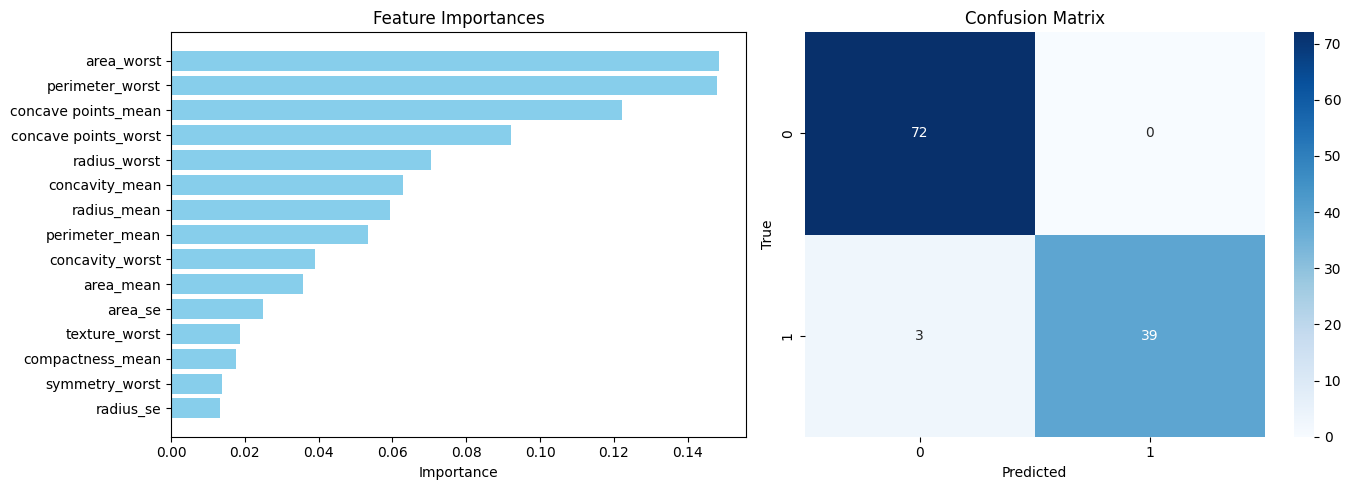

In [39]:
modelEvaluation(mamaPipe, X, y, X_test, y_test)

# Cáncer de estómago

In [40]:
gastricData = pd.read_csv("../data/data_sample.csv")

Dimensiones de X después de convertir texto a números: (2124, 23)

 hiperparámetros 
Best parameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 10}
Best CV F1-macro: 0.4935806081175049

 Evaluando Modelo de Cáncer Gástrico 
CV Accuracy: 81.93%
Accuracy: 82.35%

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       384
           1       0.16      0.20      0.18        41

    accuracy                           0.82       425
   macro avg       0.54      0.54      0.54       425
weighted avg       0.84      0.82      0.83       425



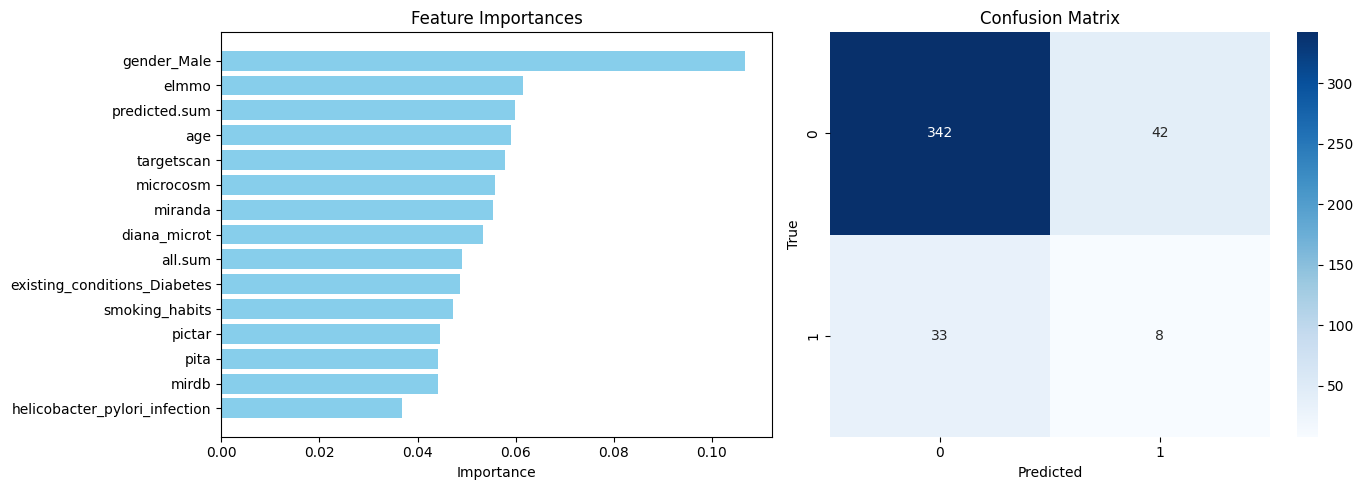

In [41]:
gastricData.head()
cols_to_drop = [
    'mature_mirna_acc', 'mature_mirna_id', 
    'target_symbol', 'target_entrez', 'target_ensembl', 
    'target'
]

if 'biopsy_results' in gastricData.columns:
    cols_to_drop.append('biopsy_results')

X = gastricData.drop(columns=cols_to_drop, errors='ignore')
y = gastricData['target'] 

X = pd.get_dummies(X, drop_first=True)

print(f"Dimensiones de X después de convertir texto a números: {X.shape}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

print("\n hiperparámetros ")
gastric_model = tuneHyperparameters(X_train, y_train)

print("\n Evaluando Modelo de Cáncer Gástrico ")
modelEvaluation(gastric_model, X_train, y_train, X_test, y_test)

# Cáncer de cuello uterino

In [42]:
cervicalData = pd.read_csv("../data/cervical-cancer_csv.csv")

In [43]:
cervicalData.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


In [44]:
cervicalData.isnull().sum()

Age                                     0
Number of sexual partners              25
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               103
Hormonal Contraceptives (years)       103
IUD                                   112
IUD (years)                           112
STDs                                  100
STDs (number)                         100
STDs:condylomatosis                   100
STDs:cervical condylomatosis          100
STDs:vaginal condylomatosis           100
STDs:vulvo-perineal condylomatosis    100
STDs:syphilis                         100
STDs:pelvic inflammatory disease      100
STDs:genital herpes                   100
STDs:molluscum contagiosum            100
STDs:AIDS                             100
STDs:HIV                              100
STDs:Hepatitis B                  

In [45]:
cervicalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 835 non-null    int64  
 1   Number of sexual partners           810 non-null    float64
 2   First sexual intercourse            828 non-null    float64
 3   Num of pregnancies                  779 non-null    float64
 4   Smokes                              822 non-null    float64
 5   Smokes (years)                      822 non-null    float64
 6   Smokes (packs/year)                 822 non-null    float64
 7   Hormonal Contraceptives             732 non-null    float64
 8   Hormonal Contraceptives (years)     732 non-null    float64
 9   IUD                                 723 non-null    float64
 10  IUD (years)                         723 non-null    float64
 11  STDs                                735 non-n

In [46]:
cervicalData = cervicalData.replace('?', np.nan)
cervicalData = cervicalData.apply(pd.to_numeric)

target = 'Biopsy'
y = cervicalData[target]

columnas_medicas = ['Schiller', 'Hinselmann', 'Citology', 'Biopsy']
X = cervicalData.drop(columnas_medicas, axis=1)

X = X.fillna(X.median())

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, max_depth=5)
model.fit(X_train, y_train)



,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


CV Accuracy: 90.87%
Accuracy: 91.62%

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       156
           1       0.29      0.18      0.22        11

    accuracy                           0.92       167
   macro avg       0.61      0.57      0.59       167
weighted avg       0.90      0.92      0.91       167



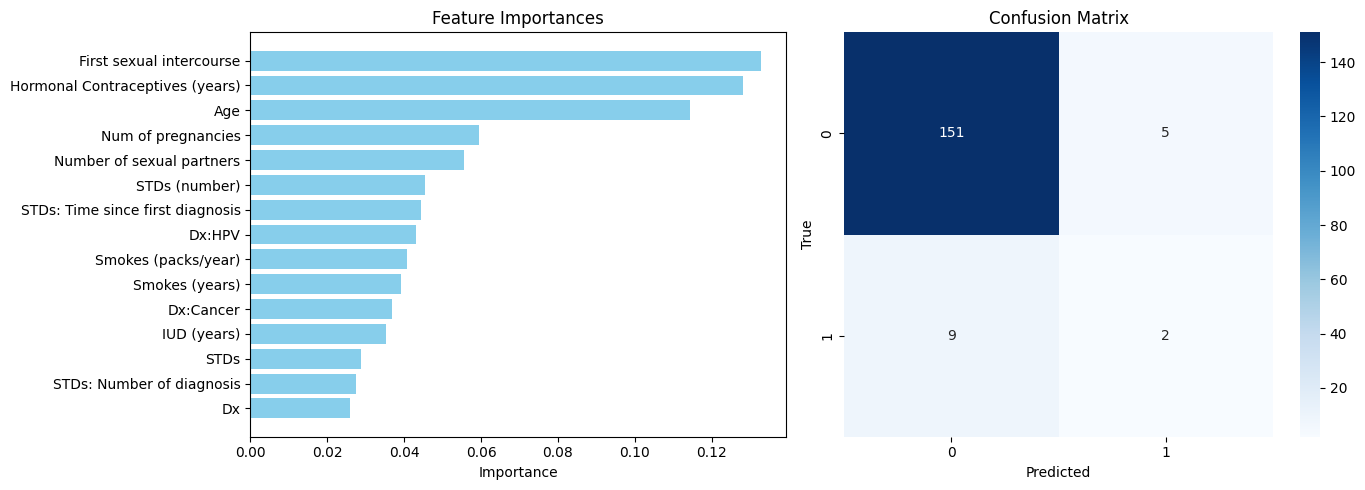

In [48]:
modelEvaluation(model, X_train, y_train, X_test, y_test)

**GENERAR LOS PLK**

In [ ]:
def exportar_modelo(modelo, dataframe_original, cols_a_excluir, nombre_prefijo):
    if modelo is None:
        print(f"El modelo para {nombre_prefijo} no está cargado en memoria.")
        return
    if dataframe_original is None:
        print(f"El dataframe para {nombre_prefijo} no está cargado en memoria.")
        return

    try:
        cols_finales = dataframe_original.drop(columns=cols_a_excluir, errors='ignore').columns.tolist()

        joblib.dump(modelo, f'modelo_{nombre_prefijo}_final.pkl')
        joblib.dump(cols_finales, f'columnas_{nombre_prefijo}.pkl')
        
    except Exception as e:
        print(f"Error al guardar {nombre_prefijo}: {e}\n")

# Pulmón
modelo_pulmon = locals().get('pulmonPipe', None)
data_pulmon   = locals().get('pulmonData', None)

# Próstata
modelo_prostata = locals().get('prostataPipe', None)
data_prostata   = locals().get('prostataData', None)

# Mama
modelo_mama = locals().get('mamaPipe', None)
data_mama   = locals().get('mamaData', None)

# Cervical
modelo_cervical = locals().get('model', None) 
data_cervical   = locals().get('cervicalData', None)

# Gástrico
modelo_gastrico = locals().get('gastric_model', None)
data_gastrico   = locals().get('gastricData', None)

# A. PULMÓN
exportar_modelo(modelo_pulmon, data_pulmon, cols_a_excluir=['LUNG_CANCER'], nombre_prefijo='pulmon')

# B. PRÓSTATA
exportar_modelo(modelo_prostata, data_prostata, cols_a_excluir=['diagnosis_result'], nombre_prefijo='prostata')

# C. MAMA
exportar_modelo(modelo_mama, data_mama, cols_a_excluir=['id', 'diagnosis', 'Unnamed: 32'], nombre_prefijo='mama')

# D. CERVICAL
exportar_modelo(modelo_cervical, data_cervical, cols_a_excluir=['Schiller', 'Hinselmann', 'Citology', 'Biopsy'], nombre_prefijo='cervical')

# E. GÁSTRICO (Manejo especial de dummies)
if modelo_gastrico is not None and data_gastrico is not None:
    try:
        cols_drop = ['mature_mirna_acc', 'mature_mirna_id', 'target_symbol', 
                     'target_entrez', 'target_ensembl', 'target', 'biopsy_results']
        
        X_temp = data_gastrico.drop(columns=cols_drop, errors='ignore')
        X_temp = pd.get_dummies(X_temp, drop_first=True)
        cols_gastrico = X_temp.columns.tolist()
        
        joblib.dump(modelo_gastrico, 'modelo_gastrico_final.pkl')
        joblib.dump(cols_gastrico, 'columnas_gastrico.pkl')
    except Exception as e:
        print(f"Error en Gástrico: {e}\n")
else:
    print("Gástrico saltado ya que no se encontraron las variables.")
